# Implement a custom Autoencoder with Koopman layer

This code is to load a model (only)

## Version Control

To Do:
1) Account for trailing batch - Make robust (fixed issue by reshaping input data)
4) Validation data has different batch size. Address when HP training

## Setup

In [1]:
import tensorflow as tf
import matplotlib as mpl
from matplotlib import pyplot as plt
from tensorflow import keras

import  numpy as np
import pandas as pd


import matplotlib.colors as mcol
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.animation as animation


import time 
import os

import glob

In [2]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [71]:
#from google.colab import drive
#drive.mount('/gdrive')

Comment out if don't need

In [72]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


# Load the Model from Solid Ground 3 and test on Solid ground 1 and 2 datasets

In [3]:
new_model = tf.keras.models.load_model('checkpoints/doggo_Trained_Model', compile=False)
new_model.summary()

Model: "Koopman_AE_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_model (EncoderModel  multiple                 8480      
 )                                                               
                                                                 
 koopman__model (Koopman_Mod  multiple                 256       
 el)                                                             
                                                                 
 decoder_model (DecoderModel  multiple                 9700      
 )                                                               
                                                                 
Total params: 18,436
Trainable params: 18,436
Non-trainable params: 0
_________________________________________________________________


## Load data

In [4]:
doggo_train = pd.read_csv('Rigid Ground Data/train_data.csv', sep=',').values
doggo_test =pd.read_csv('Rigid Ground Data/test_data_overall.csv', sep=',').values

In [5]:
desiredStates = ['theta', 'theta_dot',  'gamma', 'gamma_dot']
input_dim = len(desiredStates)
output_dim = input_dim

doggo_train = doggo_train[:,0:input_dim]
doggo_test = doggo_test[:,0:input_dim]


filePath = "Graphs and Animations"
fileNames = [filePath + '/Rigid_Ground_1*']


trajLength = 64 #length of each trajectory in the dataset
numTraj_train = 16 #total number of trajectories in the dataset
numTraj_test = 76

batch_size = int(256) # Number of snapshots in each batch
numTraj_batch = int(batch_size/trajLength)
input_dim = 4

num_batches_train =  int(trajLength*numTraj_train/batch_size)
num_batches_test = int(trajLength*numTraj_test/batch_size)


In [76]:
numTraj_batch*trajLength

256

In [6]:
doggo_train = np.asarray(doggo_train).astype('float32')
doggo_test = np.asarray(doggo_test).astype('float32')

In [7]:
print("Size of doggo_train:", len(doggo_train))
print("Size of doggo_test:", len(doggo_test))

Size of doggo_train: 1024
Size of doggo_test: 4864


### Make into dataset

In [8]:
# Normalize the data
min_val = tf.reduce_min(doggo_train)
max_val = tf.reduce_max(doggo_train)

doggo_train = (doggo_train - min_val) / (max_val - min_val)
doggo_test = (doggo_test - min_val) / (max_val - min_val)

train_data = tf.cast(doggo_train[0:batch_size*num_batches_train], tf.float32)
test_data = tf.cast(doggo_test, tf.float32)

In [9]:
x_train = train_data
y_train = train_data

# Animate Setup

In [81]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)

In [82]:
mp4FilePath = 'mp4/'
try:
    os.mkdir(mp4FilePath)
except OSError as exc:
    print(exc.errno)

17


In [83]:
def animateStatesError(middleLine, boundLine, desiredStates:list, titlePrefix, mp4FilePath = 'mp4/', ifBoundLine=True, xlim=[0,64], ylim=[0,1]):
    '''
    Given the average trajectory error, standard deviation error, and desired states,
    animate the trajectory with given legend into a mp4 under the mp4 folder

    Parameters:
    -----------
    middleLine: ndarray
        Trajectory of the middle line (nxlen(desiredStates))
    boundLine: ndarray
        Trajectory of the bound for upper and lower bound (+/- stdDev)
    desiredStates: list
        List of the desired states
    titlePrefix: str
        Prefix title to save into mp4FilePath
    mp4FilePath: str
        Directory path to save mp4
    ifBoundLine: Boolean
        ifBoundLine is true, graphs with bounded fill between lines, else just graphs middle line
    xlim: list
        Limit of plot axis in x direction
    ylim: list
        Limit of axis in y direction


    Return:
    ---------
    None
    '''
    for j in range(np.shape(middleLine)[1]):
        # Set up figure, axis, and plot element want to animate
        fig, ax = plt.subplots(figsize=(10,6))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        line, = ax.plot([],[], lw=1, label=desiredStates[j].replace("_", " "))
        plt.style.use('default')
        plt.legend()
        plt.tight_layout()

        # Initialize function: plot the background of each frame
        def init():
            line.set_data([], [])

            return line,


        # animation function called sequentially
        def animate(i, j):
            x = range(len(middleLine[0:i,j]))
            data = middleLine[0:i,j] #select data range
            line.set_data(x,data)
            line.set_color('#1f77b4')
        
            if ifBoundLine:
                p = plt.fill_between(range(len(boundLine[0:i,j])), middleLine[0:i,j]-boundLine[0:i,j], 
                                middleLine[0:i,j]+boundLine[0:i,j], facecolor='lightsteelblue')
                return line, p,
            else:
                return line,

        anim = animation.FuncAnimation(fig, animate, init_func=init, frames=128,
                                    interval=10, repeat=True, blit=True, fargs=(j,))

        anim.save(mp4FilePath+titlePrefix+'_'+ desiredStates[j]+'.mp4', writer=writer, dpi=300)
        plt.close()

In [84]:
def animateStates(predictedLine, gTruthLine, label1, label2, desiredStates:list, titlePrefix, mp4FilePath = 'mp4/', ifGTruthLine=True, xlim=[0,64], ylim=[0,1]):
    '''
    Given the predicted and ground truth trajectory, as well as desired states,
    animate the trajectory with given legend into a mp4 under the mp4FilePath folder

    Parameters:
    -----------
    predictedLine: ndarray
        Trajectory of the predicted line (nxlen(desiredStates))
    gTruthLine: ndarray
        Trajectory of the ground truth line (+/- stdDev)
    label1: str
        Label for predicted line (suffix)
    label2: str
        Label for ground truth line (suffix)
    desiredStates: list
        List of the desired states
    titlePrefix: str
        Prefix title to save into mp4FilePath
    mp4FilePath: str
        Directory path to save mp4
    ifBoundLine: Boolean
        ifBoundLine is true, graphs with bounded fill between lines, else just graphs middle line

    Return:
    ---------
    None
    '''
    for j in range(np.shape(predictedLine)[1]):
        # Set up figure, axis, and plot element want to animate
        fig, ax = plt.subplots(figsize=(10,6))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        line, = ax.plot([],[], lw=2, linestyle='--', label=desiredStates[j].replace("_", " ") + " " + label1)
        line.set_color('C0')
        if ifGTruthLine:
            line2, = ax.plot([],[], lw=2, linestyle='--', label=desiredStates[j].replace("_", " ") + " " + label2)
            line2.set_color('C1')
            plt.setp(line2, linestyle='-')
        
        plt.style.use('default')
        plt.legend()
        plt.tight_layout()

        # Initialize function: plot the background of each frame
        def init():
            line.set_data([], [])
            if ifGTruthLine:
                line2.set_data([],[])
            return line,


        # animation function called sequentially
        def animate(i, j):
            x = range(len(predictedLine[0:i,j]))
            data = predictedLine[0:i,j] #select data range
            line.set_data(x,data)
            if ifGTruthLine:
                line2.set_data(x, gTruthLine[0:i,j])
          
            return line,

        anim = animation.FuncAnimation(fig, animate, init_func=init, frames=128,
                                    interval=10, repeat=True, blit=True, fargs=(j,))

        anim.save(mp4FilePath+titlePrefix+'_'+ desiredStates[j]+'.mp4', writer=writer, dpi=300)
        plt.close()

# Graphing Error Section

#### Average Error Function

In [85]:
def preProcessForAvg(input, numTraj_batch, trajLength, num_batches, desiredStates, model):
    '''
    Given input, the number of trajectory in each batch, and the trajector length, outputs
    batch data concatenated vertically on top of one another by calling the Koopman AE class

    Parameters:
    -----------
    input: Tensor
        Input data to reshape into outputs
    numTraj_batch: int
        Number of trajectory per batch
    trajLength: int
        Number of snapshots in a trajectory
    desiredStates: list
        List of states
    model: Koopman AE keras model
        Koopman AE model to propagate data

    Return:
    ----------
    x1_all: tensor
        Copy of input (No need for change) (Ground Truth)
    x2_all: tensor
        Concatenated tensor of 1 time shifted data for all batches (Ground Truth)
    x3_all: tensor
        Concatenated tensor of 1 time step shifted data for all batches (x2_all=x3_all) (Ground Truth)
    out1_all: tensor
        Reconstruction of input (parameter) using the Koopman AE class
    out2_all: tensor
        Predicted output from Koopman model of concatenated tensors of 1 time shifted data for all batches
    out3_all: tensor
        Predicted n time step output from Koopman model of concatenated tensors data for all batches
    '''
    
    x2_all = []
    out1_all = []
    out2_all = []
    out3_all = []
    x = input

    for i in range(num_batches):
        x2 = []
        
        for j in range(numTraj_batch):
            x2.append(x[(i*numTraj_batch+j)*trajLength+1:(i*numTraj_batch+j+1)*trajLength])
        
        x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input for a batch
        x2_all.append(x2)
        
        x_input = x[i*numTraj_batch*trajLength:(i+1)*numTraj_batch*trajLength]
        
        out1, out2, out3 = model(x_input)
        out1_all.append(out1)
        out2_all.append(out2)
        out3_all.append(out3)
        
    x1_all = x
    x2_all = tf.reshape(x2_all,(-1,len(desiredStates)))
    x3_all = x2_all
    out1_all = tf.reshape(out1_all,(-1,len(desiredStates)))
    out2_all = tf.reshape(out2_all,(-1,len(desiredStates)))
    out3_all = tf.reshape(out3_all,(-1,len(desiredStates)))


    '''
    print(tf.shape(x2_all))
    print(tf.shape(out1_all))
    print(tf.shape(out2_all))
    print(tf.shape(out3_all))
    '''

    return x1_all, x2_all, x3_all, out1_all, out2_all, out3_all

In [86]:
def avgTrajError(gTruth, predicted, trajLength, numTraj):
    '''
    Get the average trajectory error with min and max values (Maybe std dev better)

    Parameters:
    -----------
    gTruth: tensor or ndarray
        Ground Truth matrix
    predicted: tensor or ndarray
        Predicted matrix
    trajLength: int
        Length of trajectory
    numTraj: int
        Number of trajectory (total?)
    

    Return:
    ----------
    avgErrorList: list
        List of average errors of all trajectories (each index is the avg error of the states at a point of time along the trajectory)
    
    errorList: list
        List of error of all states and trajectory
    '''
    errorList = []
    avgErrorList = []
    numStates = len(gTruth[0,:])
    for i in range(numTraj):
        '''
        print("Gtruth")
        print(np.array(gTruth)[i*trajLength:(i+1)*trajLength,:])
        print("Predicted")
        print(np.array(predicted[i*trajLength:(i+1)*trajLength,:]))
        print("---Loop---")
        '''
        errorList.append(np.array(gTruth)[i*trajLength:(i+1)*trajLength,:] - np.array(predicted[i*trajLength:(i+1)*trajLength,:]))
    
    #print("Error List")
    #print(np.shape(errorList[0]))
    
    for j in range(trajLength):
        #print("Length of Traj %d"% j)
        for k in range(numTraj):
            #print("Traj: %d"% k)
            if k == 0:
                avgErrorList.append(errorList[k][j,:])
            else:
                #print(avgErrorList[j])
                avgErrorList[j] = (k*avgErrorList[j]+errorList[k][j,:])/(k+1) # Recursive average formula
    return avgErrorList, errorList

# Test Graphs

In [19]:
saveTestOutputPath = 'testOutputGraph/'
try:
    os.mkdir(saveTestOutputPath)
except OSError as exc:
    print(exc.errno)

17


In [88]:
nx1_all,nx2_all,nx3_all,nout1_all,nout2_all,nout3_all = preProcessForAvg(doggo_test, numTraj_batch, trajLength, num_batches_test, desiredStates, new_model)

### batch traj plots

In [108]:
for i in range(len(desiredStates)):
    #plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(nx1_all[0:batch_size,i], label="Ground Truth")
    plt.plot(nout1_all[0:256,i],'--',label="Reconstruction")
    plt.ylabel("Reconstruction")
    plt.xlabel("Time Step")
    title = desiredStates[i]
    plt.title(title)
    plt.legend()
    #plt.ylim((min1,max1))
    plt.savefig(saveTestOutputPath+'test_recon_'+title+'.png', dpi=300)
    plt.close()

In [109]:
for i in range(len(desiredStates)):
    #plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(nx2_all[0:batch_size,i], label="Ground Truth")
    plt.plot(nout2_all[0:batch_size,i],'--',label=" One time step prediction")
    plt.ylabel("Forward Time Shift Prediction")
    plt.xlabel("Time Step")
    title = desiredStates[i]
    plt.title(title)
    plt.legend()
    #plt.ylim((min2,max2))
    plt.savefig(saveTestOutputPath+'test_fTimeShift_'+title+'.png', dpi=300)
    plt.close()

In [110]:
for i in range(len(desiredStates)):
    #plt.figure(figsize=(8,4))
    plt.style.use('default')
    plt.plot(nx3_all[0:batch_size,i], label="Ground Truth")
    plt.plot(nout3_all[0:batch_size,i],'--',label="Full trajectory prediction")
    plt.ylabel("Linear Prediction")
    plt.xlabel("Time Step")
    title = desiredStates[i]
    plt.title(title)
    plt.legend()
    #plt.ylim((min3,max3))
    plt.savefig(saveTestOutputPath+'test_linPred_'+title+'.png', dpi=300)
    plt.close()

# Animation on Test

In [92]:
avgTrajErrorList, errorList = avgTrajError(nx1_all, nout1_all, trajLength, numTraj_test)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'test_recon_error', mp4FilePath, ifBoundLine=False)

avgTrajErrorList, errorList = avgTrajError(nx2_all, nout2_all, trajLength-1, numTraj_test)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'test_fTimeShiftPred_error', mp4FilePath, ifBoundLine=False)

avgTrajErrorList, errorList = avgTrajError(nx3_all, nout3_all, trajLength-1, numTraj_test)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'test_linPred_error', mp4FilePath, ifBoundLine=False)

Trajectory

In [104]:
animateStates(nout1_all,nx1_all,'Reconstruction','Truth',  desiredStates, 'test_traj_recon',xlim=[0,64], ylim=[-0.1,0.1])
animateStates(nout2_all,nx2_all,'Forward Time Shift','Truth', desiredStates, 'test_traj_FTimeShiftPred', xlim=[0,64], ylim=[-0.1,0.1])
animateStates(nout3_all,nx3_all,'Lin Pred','Truth', desiredStates, 'test_traj_linPred', xlim=[0,64], ylim=[-0.1,0.1])

### Error Graphs with std dev

In [94]:
saveErrorPath = 'errorGraph/'
try:
    os.mkdir(saveErrorPath)
except OSError as exc:
    print(exc.errno)

17


### Reconstruction error graph with std dev

In [95]:
avgTrajErrorList, errorList = avgTrajError(nx1_all, nout1_all, trajLength, numTraj_test)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

In [96]:
for i in range(len(desiredStates)):
    plt.figure()
    plt.style.use('default')
    plt.plot(avgTrajErrorArray[:,i])
    plt.fill_between(range(len(errorStdDevArray[:,i])), avgTrajErrorArray[:,i]-errorStdDevArray[:,i], avgTrajErrorArray[:,i]+errorStdDevArray[:,i],alpha = 0.3)
    title=desiredStates[i]
    plt.title(title)
    plt.ylabel("Reconstruction Error")
    plt.xlabel("Time Step")
    #plt.ylim((0,1))
    plt.savefig(saveErrorPath+'recon_error_'+title+'.png', dpi=300)
    plt.close()

### Forward time shift prediction graphs with std dev (use traj len - 1)

In [97]:
avgTrajErrorList, errorList = avgTrajError(nx2_all, nout2_all, trajLength-1, numTraj_test)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

In [98]:
errorArray.shape

(76, 63, 4)

In [99]:
for i in range(len(desiredStates)):
    plt.figure()
    plt.style.use('default')
    plt.plot(avgTrajErrorArray[:,i])
    plt.fill_between(range(len(errorStdDevArray[:,i])), avgTrajErrorArray[:,i]-errorStdDevArray[:,i], avgTrajErrorArray[:,i]+errorStdDevArray[:,i],alpha = 0.3)
    title=desiredStates[i]
    plt.title(title)
    plt.ylabel("Forword time shift error")
    plt.xlabel("Time Step")
    #plt.ylim((0,1))
    plt.savefig(saveErrorPath+'fTimeshift_error_'+title+'.png', dpi=300)
    plt.close()

#### Linear prediction graphs with std dev (use traj len -1)

In [100]:
avgTrajErrorList, errorList = avgTrajError(nx3_all, nout3_all, trajLength-1, numTraj_test)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

In [101]:
for i in range(len(desiredStates)):
    plt.figure()
    plt.style.use('default')
    plt.plot(avgTrajErrorArray[:,i])
    plt.fill_between(range(len(errorStdDevArray[:,i])), avgTrajErrorArray[:,i]-errorStdDevArray[:,i], avgTrajErrorArray[:,i]+errorStdDevArray[:,i],alpha = 0.3)
    title=desiredStates[i]
    plt.title(title)
    plt.ylabel("Linear prediction error")
    plt.xlabel("Time Step")
    #plt.ylim((0,1))
    plt.savefig(saveErrorPath+'lin_pred_error_'+title+'.png', dpi=300)
    plt.close()

In [102]:
animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'test_recon_error', mp4FilePath, ifBoundLine=False)
animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'test_fTimeShiftPred_error', mp4FilePath, ifBoundLine=False)
animateStatesError(avgTrajErrorArray, errorStdDevArray, desiredStates, 'test_linPred_error', mp4FilePath, ifBoundLine=False)

### Eigenfunctions plots

In [12]:
K = new_model.koopman.get_weights()
K = tf.constant(K, dtype=tf.float32)
eig_vals, right_eig_vectors = tf.linalg.eig(K)
W = tf.transpose(tf.linalg.inv(right_eig_vectors))
Z = new_model.enc(test_data)
complex_vals = tf.math.imag(tf.zeros(tf.shape(Z)))
Z = tf.complex(Z, complex_vals)
Psi = tf.linalg.matmul(Z, W)
Psi_mag = tf.math.abs(Psi)
Psi_ang = tf.math.angle(Psi)

In [13]:
print(tf.math.abs(eig_vals))

tf.Tensor(
[[0.02967063 0.02967063 0.08013412 0.08428656 0.10536727 0.1053673
  0.14927147 0.14927153 0.15426737 0.19128661 0.19128667 0.21016501
  0.21016513 0.2130485  0.99546427 0.9954644 ]], shape=(1, 16), dtype=float32)


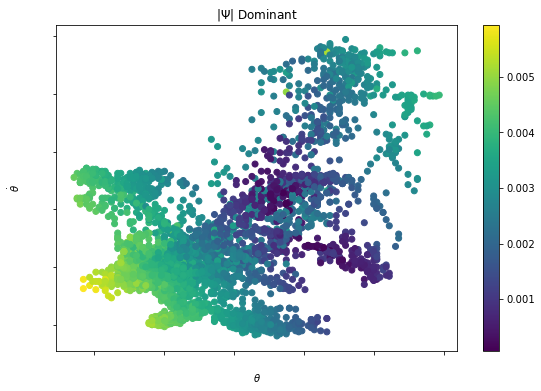

In [26]:
P0 = plt.scatter(test_data[0:,0], test_data[0:,1], c=Psi_mag[15,0:].numpy(),norm=None)
plt.colorbar(P0)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\dot\theta$")
# Turn off tick labels
plt.xticks(color='w')
plt.yticks(color='w')
title = '$|\Psi|$ Dominant'
plt.title(title)
plt.savefig(saveTestOutputPath+'phaseP_eigMag'+'.png', dpi=300)
#plt.close()

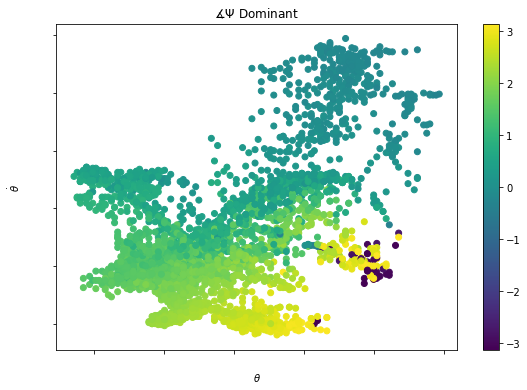

In [28]:
P0 = plt.scatter(test_data[:,0], test_data[:,1], c=Psi_ang[14,:].numpy())
plt.colorbar(P0)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\dot\theta$")
# Turn off tick labels
plt.xticks(color='w')
plt.yticks(color='w')
title = '$\measuredangle\Psi$ Dominant'
plt.title(title)
plt.savefig(saveTestOutputPath+'phaseP_eigAngle'+'.png', dpi=300)

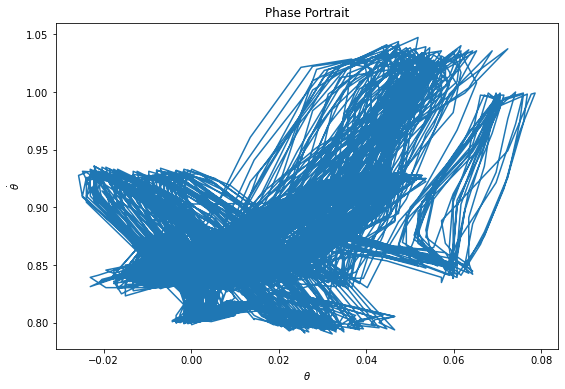

In [23]:
plt.figure()
plt.plot(test_data[:,0],test_data[:,1])
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\dot\theta$")
plt.title("Phase Portrait")
plt.savefig(saveTestOutputPath+'phase'+'.png', dpi=300)